In [1]:
import geopandas as gpd

## Cities


In [3]:
# Download the cities cadastre data
# See https://cadastre.data.gouv.fr/datasets/cadastre-etalab

!mkdir -p ../data/cadastre
!wget https://cadastre.data.gouv.fr/data/etalab-cadastre/2025-01-01/geojson/france/cadastre-france-communes.json.gz -O ../data/cadastre/cadastre-france-communes.json.gz
!gunzip ../data/cadastre/cadastre-france-communes.json.gz

In [2]:
cities = gpd.read_file("../data/cadastre/cadastre-france-communes.json")
cities

,id,nom,created,updated,geometry
0,03011,AUROUER,2005-06-06,2022-03-14,"MULTIPOLYGON (((3.29284 46.65822, 3.29285 46.6..."
1,01011,APREMONT,2023-02-21,2024-08-21,"MULTIPOLYGON (((5.64362 46.17778, 5.64395 46.1..."
2,02001,ABBECOURT,2013-12-17,2018-08-06,"MULTIPOLYGON (((3.17881 49.58305, 3.1789 49.58..."
3,04001,AIGLUN,2012-01-17,2021-03-16,"MULTIPOLYGON (((6.14334 44.0416, 6.14357 44.04..."
4,05003,AIGUILLES,2006-12-14,2017-03-17,"MULTIPOLYGON (((6.91207 44.73711, 6.91299 44.7..."
...,...,...,...,...,...
34932,71382,SAINT-AGNAN,2008-05-28,2015-03-25,"MULTIPOLYGON (((3.89278 46.48125, 3.89288 46.4..."
34933,71411,SAINT-EUGENE,2012-09-17,2022-03-03,"MULTIPOLYGON (((4.19894 46.68708, 4.19902 46.6..."
34934,71155,CRONAT,2008-05-19,2022-01-18,"MULTIPOLYGON (((3.65522 46.68767, 3.6557 46.68..."
34935,71239,ISSY-L EVEQUE,2015-05-19,2017-08-21,"MULTIPOLYGON (((3.97398 46.6477, 3.97431 46.64..."


<Axes: >

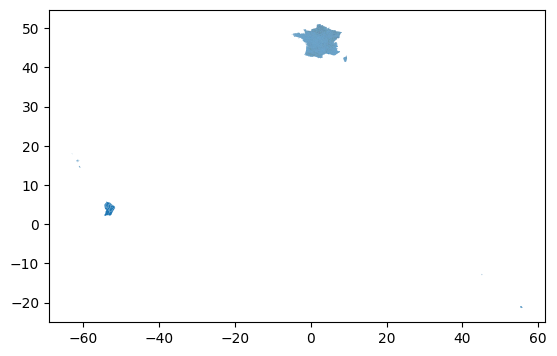

In [3]:
cities.plot()

In [4]:
# Remove the overseas cities
cities = cities[
    ~cities["id"].str.startswith(("971", "972", "973", "974", "975", "976"))
]

<Axes: >

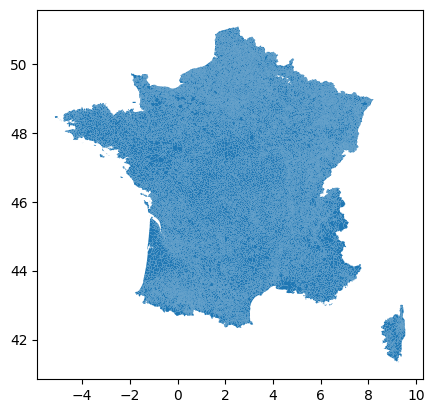

In [5]:
cities.plot()

In [6]:
# Convert CRS to Lambert93 like the other layers
cities = cities.to_crs(epsg=2154)

In [24]:
# Save to disk, we'll upload it to S3 at the end of the notebook
cities[["id", "nom", "geometry"]].rename(
    columns={"id": "code_insee", "nom": "name"}
).to_file("../data/cadastre/cadastre_france_cities.fgb", index=False)

## Departments


In [ ]:
# Download the departments cadastre data
# See https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/

!wget https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce -O ../data/cadastre/departements-20180101-shp.zip

In [11]:
departments = gpd.read_file("../data/cadastre/departements-20180101-shp.zip")
departments

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
0,974,La Réunion,FR940,fr:La Réunion,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,11,Aude,FR811,fr:Aude (département),6343.0,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,43,Haute-Loire,FR723,fr:Haute-Loire,5003.0,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,13,Bouches-du-Rhône,FR823,fr:Bouches-du-Rhône,5247.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,47,Lot-et-Garonne,FR614,fr:Lot-et-Garonne,5385.0,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...,...,...,...,...
97,56,Morbihan,FR524,fr:Morbihan,6870.0,"MULTIPOLYGON (((-3.73508 48.1114, -3.73507 48...."
98,25,Doubs,FR431,fr:Doubs (département),5256.0,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,39,Jura,FR432,fr:Jura (département),5049.0,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,07,Ardèche,FR712,fr:Ardèche (département),5566.0,"POLYGON ((3.8611 44.71118, 3.8611 44.71151, 3...."


<Axes: >

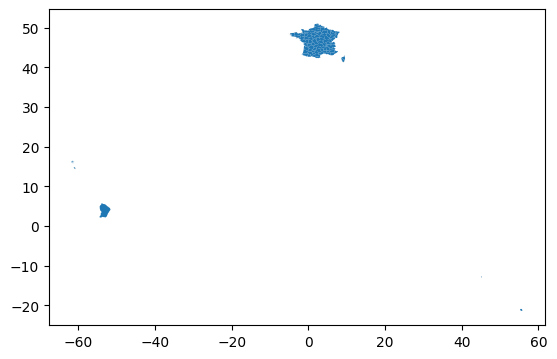

In [13]:
departments.plot()

In [ ]:
# Remove the overseas departments
departments = departments[
    ~departments["code_insee"].isin(("971", "972", "973", "974", "975", "976"))
]

<Axes: >

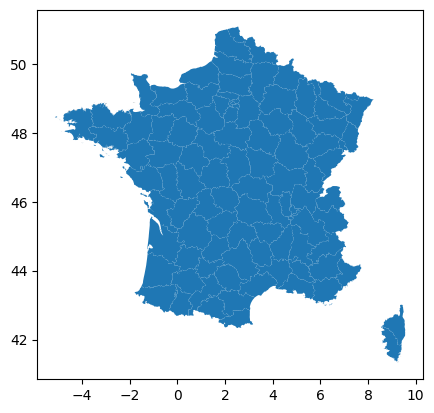

In [18]:
departments.plot()

In [25]:
# Convert CRS to Lambert93 like the other layers
departments = departments.to_crs(epsg=2154)

In [26]:
# Save to disk, we'll upload it to S3 next
departments[["code_insee", "nom", "geometry"]].rename(columns={"nom": "name"}).to_file(
    "../data/cadastre/cadastre_france_departments.fgb", index=False
)

## Upload to S3


In [28]:
!aws s3 cp ../data/cadastre/cadastre_france_cities.fgb s3://brigade-coupe-rase-s3/analytics/data/cadastre/cadastre_france_cities.fgb --profile d4g-s13-brigade-coupes-rases
!aws s3 cp ../data/cadastre/cadastre_france_departments.fgb s3://brigade-coupe-rase-s3/analytics/data/cadastre/cadastre_france_departments.fgb --profile d4g-s13-brigade-coupes-rases

upload: ../data/cadastre/cadastre_france_cities.fgb to s3://brigade-coupe-rase-s3/analytics/data/cadastre/cadastre_france_cities.fgb
upload: ../data/cadastre/cadastre_france_departments.fgb to s3://brigade-coupe-rase-s3/analytics/data/cadastre/cadastre_france_departments.fgb


In [29]:
!aws s3 ls s3://brigade-coupe-rase-s3/analytics --recursive --profile d4g-s13-brigade-coupes-rases

2025-02-25 09:31:33   96946219 analytics/data
2025-02-28 13:19:58  121412416 analytics/data/abusive_clear_cuts/abusive_clear_cuts_2024.fgb
2025-03-02 18:53:00  517567704 analytics/data/cadastre/cadastre_france_cities.fgb
2025-03-02 18:53:03   28085888 analytics/data/cadastre/cadastre_france_departments.fgb
2025-02-21 18:43:11  558882864 analytics/data/ign/bdalti25/slope_gte_30.fgb
2025-02-21 18:42:55   32993275 analytics/data/ign/bdalti25/slope_gte_30.tif
2025-02-25 09:58:17   96946219 analytics/data/sufosat/mosaics_tropisco_warnings_france_date.tif
2025-02-25 10:08:57   76601154 analytics/data/sufosat/mosaics_tropisco_warnings_france_prob.tif
2025-02-21 13:26:51  120737768 analytics/data/sufosat/sufosat_clear_cuts_2024.fgb
